In [1]:
import numpy as np
import squigglepy as sq
import matplotlib.pyplot as plt

from pprint import pprint
from functools import partial
from datetime import datetime, timedelta
from matplotlib.ticker import FuncFormatter


O3_LAUNCH_DATE = datetime(2025, 4, 16)
CLAUDE_3P7_LAUNCH_DATE = datetime(2025, 2, 24)


def run_model(model, index_date=O3_LAUNCH_DATE):
    samples = sq.sample(model, n=100_000, verbose=True)
    pprint(sq.get_percentiles(samples, digits=0))
    print('\n-\n')
    samples_ = sq.get_percentiles(samples_to_date(samples, index_date=index_date))
    samples_ = {k: v.strftime("%Y %b %d") for k, v in samples_.items()}
    pprint(samples_)
    return samples


def samples_to_date(samples, index_date=O3_LAUNCH_DATE):
    date_converter = np.vectorize(lambda x: index_date + timedelta(days=int(np.ceil(x))))
    return date_converter(samples)


def calculate_doubling_time(start_task_length, agi_task_length, doubling_time, acceleration=1):
    """
    Parameters
    ----------
    start_task_length : scalar or distribution
        Current hours needed for the reference task.
    agi_task_length : scalar or distribution
        Hours required for the task at AGI.
    initial_doubling_time : scalar or distribution (days)
        Doubling time at the *current* capability level.
    acceleration : scalar or distribution
        Multiplicative factor applied to the doubling time *after every doubling*.
        • 1.0  → constant exponential growth (baseline).
        • <1.0 → doubling time shrinks, giving super‑exponential growth.
        • >1.0 → growth slows over time.
    """
    doublings_needed = sq.dist_log(agi_task_length / start_task_length) / np.log(2)
    if acceleration == 1:
        return doublings_needed * doubling_time
    else:
        return doubling_time * (1 - acceleration**doublings_needed) / (1 - acceleration)


def calendar_days_for_doublings(
    doublings: np.ndarray,
    initial_doubling_time: float,
    acceleration: float
) -> np.ndarray:
    """Super‑exponential growth law from Chin & You (2024)."""
    if np.isclose(acceleration, 1.0):
        # pure exponential (constant doubling time)
        return doublings * initial_doubling_time
    return (
        initial_doubling_time
        * (1 - acceleration ** doublings)
        / (1 - acceleration)
    )


print('Loaded libraries')

Loaded libraries


In [2]:
def metr_model():
    days = calculate_doubling_time(start_task_length=1, agi_task_length=167, doubling_time=212, acceleration=1) # Variables from METR paper
    measurement_error_variance = sq.invlognorm(0.8, 1.5) # Add easurement error on tasks: SD fit to trend variance from Figure 12
    return days * measurement_error_variance

_ = run_model(metr_model, index_date=CLAUDE_3P7_LAUNCH_DATE) # Results should look similar to Figure 12

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:07<00:00, 12852.73it/s]


{1: 1102,
 5: 1252,
 10: 1343,
 20: 1462,
 30: 1551,
 40: 1633,
 50: 1715,
 60: 1799,
 70: 1894,
 80: 2015,
 90: 2194,
 95: 2352,
 99: 2679}

-

{1: '2028 Mar 02',
 5: '2028 Jul 30',
 10: '2028 Oct 30',
 20: '2029 Feb 25',
 30: '2029 May 26',
 40: '2029 Aug 15',
 50: '2029 Nov 05',
 60: '2030 Jan 29',
 70: '2030 May 03',
 80: '2030 Sep 01',
 90: '2031 Feb 28',
 95: '2031 Aug 05',
 99: '2032 Jun 27'}


In [3]:
def metr_model_with_o3():
    days = calculate_doubling_time(start_task_length=1.75, agi_task_length=167, doubling_time=118, acceleration=1) # Use o3 task length, o3 launch date, and the 2024-2025 doubling time
    measurement_error_variance = sq.invlognorm(0.8, 1.5) # Add measurement error on tasks: SD fit to trend variance from Figure 12
    return days * measurement_error_variance

_ = run_model(metr_model_with_o3, index_date=O3_LAUNCH_DATE)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:07<00:00, 12897.26it/s]


{1: 546,
 5: 621,
 10: 665,
 20: 724,
 30: 769,
 40: 810,
 50: 851,
 60: 893,
 70: 941,
 80: 999,
 90: 1085,
 95: 1162,
 99: 1322}

-

{1: '2026 Oct 15',
 5: '2026 Dec 28',
 10: '2027 Feb 11',
 20: '2027 Apr 10',
 30: '2027 May 25',
 40: '2027 Jul 05',
 50: '2027 Aug 15',
 60: '2027 Sep 26',
 70: '2027 Nov 14',
 80: '2028 Jan 11',
 90: '2028 Apr 06',
 95: '2028 Jun 21',
 99: '2028 Nov 28'}


In [4]:
# The simpler model with static variables from my Substack
def simple_model():
    days = calculate_doubling_time(start_task_length=3.75/60, agi_task_length=167, doubling_time=165, acceleration=1)
    shift = 100
    return days - shift

_ = run_model(simple_model, index_date=O3_LAUNCH_DATE)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:04<00:00, 20758.23it/s]


{1: 1778,
 5: 1778,
 10: 1778,
 20: 1778,
 30: 1778,
 40: 1778,
 50: 1778,
 60: 1778,
 70: 1778,
 80: 1778,
 90: 1778,
 95: 1778,
 99: 1778}

-

{1: '2030 Feb 28',
 5: '2030 Feb 28',
 10: '2030 Feb 28',
 20: '2030 Feb 28',
 30: '2030 Feb 28',
 40: '2030 Feb 28',
 50: '2030 Feb 28',
 60: '2030 Feb 28',
 70: '2030 Feb 28',
 80: '2030 Feb 28',
 90: '2030 Feb 28',
 95: '2030 Feb 28',
 99: '2030 Feb 28'}


In [5]:
print('## START task length (displayed in min) ##')

# -- DEFINE CURRENT BEST
current_best = 1.75 # o3 task length at 50% reliability?

# -- DEFINE ADJUSTMENTS
elicitation_boost = sq.mixture([[0.3, 1], # Can you get a boost to scores by iterating on scaffolding and other elicitation techniques? 30% chance no, 40% chance you can get a 1.2x speed up, 30% chance of 1.5x.
                                [0.4, 1.2],
                                [0.3, 1.5]])
                               
reliability_needed = sq.mixture([[0.2, 0.5], # What amount of reliability will we need? Probability distribution over hypotheses
                                 [0.4, 0.8],
                                 [0.2, 0.9],
                                 [0.1, 0.95],
                                 [0.1, 0.99]])

def reliability_count_to_penalty(reliability):
    r = np.asarray(reliability, dtype=float)
    reliability = np.array([0.50, 0.80, 0.90, 0.95, 0.99])
    penalty = np.array([1.0, 0.25, 0.25**2, 0.25**3, 0.25**4])
    matches = r[..., None] == reliability
    hit_any = matches.any(axis=-1)
    idx = matches.argmax(axis=-1)
    out = np.full_like(r, np.nan, dtype=float)
    out[hit_any] = penalty[idx[hit_any]]
    return out

task_type_penalty = sq.mixture([[0.1, 1],                         # 10% chance that METR's software tasks are sufficient for AGI
                                [0.3, 1 / sq.lognorm(5, 20)],     # 30% chance that true AGI tasks are 5-20x harder than METR's software tasks
                                [0.6, 1 / sq.lognorm(10, 1000)]]) # 60% chance that true AGI tasks are 10-1000x harder than METR's software tasks

# -- CREATE DISTRIBUTION
# Start with current best, add elicitation boost
start_task_length = current_best * elicitation_boost

# add reliability penalty
start_task_length = start_task_length * sq.dist_fn(reliability_needed, reliability_count_to_penalty)

# Add task type penalty
start_task_length *= task_type_penalty

# Add a minimum value of 1sec
start_task_length = sq.dist_max(1/60/60, start_task_length)

# Show samples in minutes (naturally in hours)
sq.get_percentiles((start_task_length * 60) @ 100_000, digits=2)

## START task length (displayed in min) ##


{1: 0.02,
 5: 0.02,
 10: 0.02,
 20: 0.06,
 30: 0.14,
 40: 0.29,
 50: 0.57,
 60: 1.1,
 70: 2.28,
 80: 4.33,
 90: 12.14,
 95: 31.5,
 99: 126.0}

In [6]:
print('## AGI task length (displayed in hrs) ##')
agi_task_length = sq.lognorm(80, 2000, credibility=80, lclip=40)
sq.get_percentiles(agi_task_length @ 100_000, digits=0)

## AGI task length (displayed in hrs) ##


{1: 40,
 5: 51,
 10: 80,
 20: 137,
 30: 205,
 40: 287,
 50: 396,
 60: 544,
 70: 772,
 80: 1156,
 90: 2007,
 95: 3125,
 99: 7372}

In [7]:
print('## DOUBLING TIME (displayed in days) ##')
doubling_time = sq.mixture([[0.4, 212],
                            [0.2, 118],
                            [0.1, 320],
                            [0.3, sq.lognorm(lognorm_mean=126, lognorm_sd=40)]])
sq.get_percentiles(doubling_time @ 100_000, digits=0)

## DOUBLING TIME (displayed in days) ##


{1: 68,
 5: 89,
 10: 105,
 20: 118,
 30: 118,
 40: 137,
 50: 212,
 60: 212,
 70: 212,
 80: 212,
 90: 269,
 95: 320,
 99: 320}

In [8]:
print('## ACCELERATION (displayed in days)')
acceleration = sq.mixture([[0.8, 1],
                           [0.2, 1 - sq.lognorm(0.005, 0.1, credibility=80)]])
sq.get_percentiles(acceleration @ 100_000, digits=3)

## ACCELERATION (displayed in days)


{1: 0.846,
 5: 0.951,
 10: 0.978,
 20: 1.0,
 30: 1.0,
 40: 1.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 1.0}

In [9]:
print('## SHIFT (displayed in days) ##')
shift = sq.norm(30, 30*5, credibility=80, lclip=0)
sq.get_percentiles(shift @ 100_000, digits=0)

## SHIFT (displayed in days) ##


{1: 0,
 5: 13,
 10: 30,
 20: 51,
 30: 66,
 40: 78,
 50: 90,
 60: 102,
 70: 115,
 80: 129,
 90: 150,
 95: 167,
 99: 199}

In [10]:
def adapted_metr_model():
    start_task_length_ = start_task_length * (2 ** (shift / doubling_time))
    days = calculate_doubling_time(start_task_length_, agi_task_length, doubling_time, acceleration)
    measurement_error_variance = sq.invlognorm(0.8, 1.5) # Add measurement error on tasks: SD fit to trend variance from Figure 12
    return days * measurement_error_variance

samples = run_model(adapted_metr_model)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:13<00:00, 1362.53it/s]


{1: 731,
 5: 1088,
 10: 1322,
 20: 1667,
 30: 1969,
 40: 2281,
 50: 2626,
 60: 3019,
 70: 3488,
 80: 4078,
 90: 4959,
 95: 5789,
 99: 7695}

-

{1: '2027 Apr 17',
 5: '2028 Apr 08',
 10: '2028 Nov 29',
 20: '2029 Nov 08',
 30: '2030 Sep 07',
 40: '2031 Jul 15',
 50: '2032 Jun 25',
 60: '2033 Jul 22',
 70: '2034 Nov 03',
 80: '2036 Jun 16',
 90: '2038 Nov 13',
 95: '2041 Feb 20',
 99: '2046 May 11'}


In [11]:
print('## DISTRIBUTION OF AGI ARRIVAL DATE ##')
# Convert datetime samples to years
agi_years = [s / 365 + 2025 for s in samples]
pctiles = sq.get_percentiles(agi_years, percentiles=[1, 2, 3, 4, 5, 10, 15, 20, 25, 35, 50, 60, 75, 80, 90, 95])
pprint([
    ((str(o[0]) + '%: ' + str(round(o[1], 1))) if o[1] < 2100 else '>2100') 
    for o in pctiles.items()
])
print('')
print('')
print('## DISTRIBUTION OF RELATIVE AGI ARRIVAL DATE ##')
pprint([
    ((str(o[0]) + '%: ' + str(round(o[1] - 2025, 1))) if o[1] < 2100 else '>75') + ' years from now' 
    for o in pctiles.items()
])
print('(Mean: {} years from now)'.format(int(round(np.mean([t - 2025 for t in agi_years])))))
print('')
print('')


print('## AGI ARRIVAL DATE BY BIN ##')

def bin_agi_yrs(low=None, hi=None):
    low = 2025 if low is None else low
    if hi is None:
        r = np.mean([y >= low for y in agi_years])
    else:
        r = np.mean([(y >= low) and (y <= hi) for y in agi_years])
    return round(r * 100, 1)


year_pairs = [[2025, 2026],
              [2026, 2027],
              [2027, 2028],
              [2028, 2029],
              [2029, 2030],
              [2030, 2032],
              [2032, 2035],
              [2035, 2040],
              [2040, 2050],
              [2050, 2060],
              [2060, 2070],
              [2070, 2080],
              [2080, 2090],
              [2090, 2100]]
for y in year_pairs:
    if y[0] == y[1] - 1:
        print('{}: {}%'.format(y[0], bin_agi_yrs(y[0], y[1])))
    else:
        print('{}-{}: {}%'.format(y[0], y[1]-1, bin_agi_yrs(y[0], y[1])))
print('>{}: {}%'.format(2100, bin_agi_yrs(low=2100)))
print('')
print('')

print('## AGI ARRIVAL DATE BY YEAR ##')
for y in list(range(2025, 2035)) + list(range(2035, 2100, 5)):
    print('By EOY {}: {}%'.format(y, bin_agi_yrs(hi=y+1)))
print('')

## DISTRIBUTION OF AGI ARRIVAL DATE ##
['1%: 2027.0',
 '2%: 2027.4',
 '3%: 2027.6',
 '4%: 2027.8',
 '5%: 2028.0',
 '10%: 2028.6',
 '15%: 2029.1',
 '20%: 2029.6',
 '25%: 2030.0',
 '35%: 2030.8',
 '50%: 2032.2',
 '60%: 2033.3',
 '75%: 2035.3',
 '80%: 2036.2',
 '90%: 2038.6',
 '95%: 2040.9']


## DISTRIBUTION OF RELATIVE AGI ARRIVAL DATE ##
['1%: 2.0 years from now',
 '2%: 2.4 years from now',
 '3%: 2.6 years from now',
 '4%: 2.8 years from now',
 '5%: 3.0 years from now',
 '10%: 3.6 years from now',
 '15%: 4.1 years from now',
 '20%: 4.6 years from now',
 '25%: 5.0 years from now',
 '35%: 5.8 years from now',
 '50%: 7.2 years from now',
 '60%: 8.3 years from now',
 '75%: 10.3 years from now',
 '80%: 11.2 years from now',
 '90%: 13.6 years from now',
 '95%: 15.9 years from now']
(Mean: 8 years from now)


## AGI ARRIVAL DATE BY BIN ##
2025: 0.0%
2026: 1.0%
2027: 4.1%
2028: 8.7%
2029: 11.4%
2030-2031: 22.9%
2032-2034: 25.0%
2035-2039: 20.5%
2040-2049: 6.3%
2050-2059: 0.2%
2060-2069: 0.0%
2

## Overall prediction

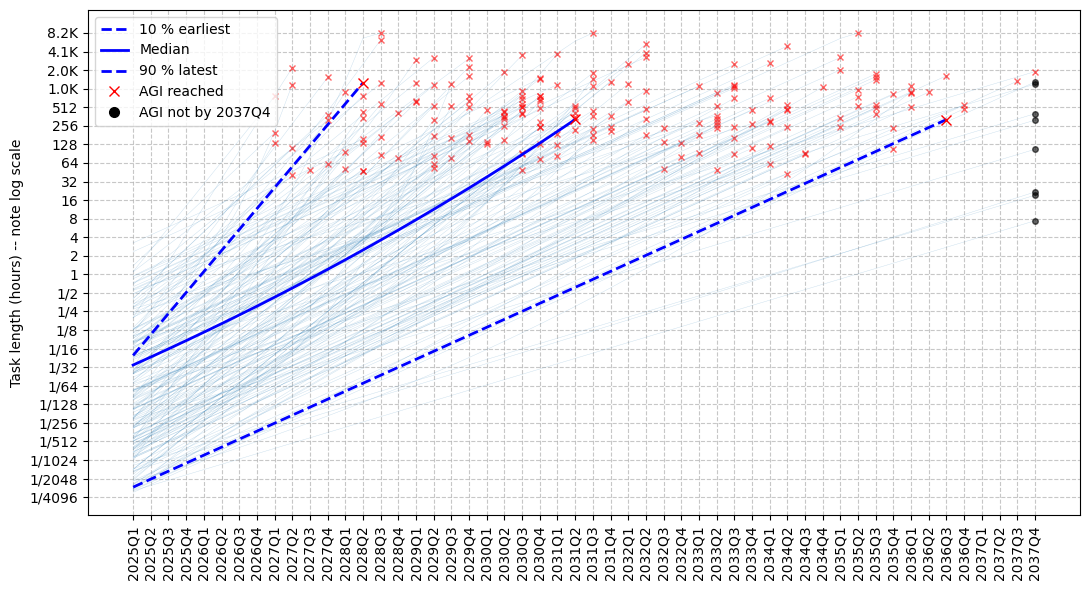

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import squigglepy as sq

DAYS_PER_QUARTER = 365 / 4

def billions_formatter(x, pos):
    if x >= 1e9:
        return f"{x/1e9:.1f}B"
    if x >= 1e6:
        return f"{x/1e6:.1f}M"
    if x >= 1e3:
        return f"{x/1e3:.1f}K"
    if x <= 0.5:
        return f"1/{1/x:.0f}"
    return f"{x:.0f}"


def _quarter_labels(n: int, start_year: int = 2025) -> list[str]:
    return [f"{start_year + q // 4}Q{q % 4 + 1}" for q in range(n + 1)]


def _y_ticks(lo: int, hi: int) -> list[int]:
    return [2 ** k for k in range(lo, hi + 1)]


def _first_curve(order, traj, reference, above):
    cmp = np.greater_equal if above else np.less_equal
    for idx in order:
        if np.all(cmp(traj[idx], reference)):
            return idx
    return order[0]


def plot_exponential_growth(
    doubling_time_days,
    starting_hours,
    agi_task_length,
    shift=0,
    acceleration=1,
    n_quarters: int = 40,
    n_samples: int = 10_000,
    n_traces: int = 100,
    max_task_power: int = 13,
    min_y_power: int = -8,
) -> None:
    max_task_hours = 2 ** max_task_power
    tau0 = sq.sample(doubling_time_days, n=n_samples)
    accel = sq.sample(acceleration, n=n_samples)
    shift = sq.sample(shift, n=n_samples)
    agi = sq.sample(sq.dist_min(max_task_hours, agi_task_length), n=n_samples)
    start = sq.sample(starting_hours, n=n_samples) * 2 ** (shift / tau0)

    quarters = np.arange(n_quarters + 1)
    traj = np.zeros((n_samples, len(quarters)))
    clip_idx = np.full(n_samples, len(quarters), dtype=int)

    for i in range(n_samples):
        tau = tau0[i]
        val = start[i]
        for j in range(len(quarters)):
            if val >= max_task_hours:
                traj[i, j:] = max_task_hours
                clip_idx[i] = j
                break
            traj[i, j] = val
            val *= 2 ** (DAYS_PER_QUARTER / tau)
            tau *= accel[i]

    reached = traj >= agi[:, None]
    first_hit = np.argmax(reached, axis=1)
    first_hit[np.all(~reached, axis=1)] = len(quarters)

    order = np.argsort(first_hit)
    median_idx = order[len(order) // 2]
    median_curve = traj[median_idx]

    idx10 = _first_curve(order[int(0.10 * n_samples):], traj, median_curve, above=True)
    idx90 = _first_curve(order[: int(0.90 * n_samples)][::-1], traj, median_curve, above=False)

    highlights = {
        "10 % earliest": (traj[idx10], first_hit[idx10], clip_idx[idx10], "b--"),
        "Median": (median_curve, first_hit[median_idx], clip_idx[median_idx], "b-"),
        "90 % latest": (traj[idx90], first_hit[idx90], clip_idx[idx90], "b--"),
    }

    plt.figure(figsize=(11, 6))
    rng = np.random.default_rng()

    for i in rng.choice(n_samples, min(n_traces, n_samples), replace=False):
        end_q = min(first_hit[i], clip_idx[i], len(quarters) - 1)
        plt.plot(
            quarters[: end_q + 1],
            traj[i, : end_q + 1],
            color="tab:blue",
            lw=0.3,
            alpha=0.25,
        )
        marker = "rx" if first_hit[i] < len(quarters) else "ko"
        plt.plot(quarters[end_q], traj[i, end_q], marker, ms=4, alpha=0.6)

    for label, (curve, hit_q, clip_q, style) in highlights.items():
        end_q = min(hit_q, clip_q, len(quarters) - 1)
        plt.plot(quarters[: end_q + 1], curve[: end_q + 1], style, lw=2, label=label)
        marker = "rx" if hit_q < len(quarters) else "ko"
        plt.plot(quarters[end_q], curve[end_q], marker, ms=7)

    plt.plot([], [], "rx", ms=7, label="AGI reached")
    plt.plot([], [], "ko", ms=7, label=f"AGI not by {_quarter_labels(n_quarters)[-1]}")
    plt.yscale("log", base=2)
    
    nonzero_values = traj[traj > 0]
    percentile_0p1 = np.percentile(nonzero_values, 0.1)
    min_y_data = int(np.floor(np.log2(percentile_0p1)))
    y_lo = max(min_y_power, min_y_data)
    
    plt.yticks(_y_ticks(lo=y_lo, hi=max_task_power))
    plt.gca().yaxis.set_major_formatter(FuncFormatter(billions_formatter))
    plt.xticks(quarters, _quarter_labels(n_quarters), rotation=90)
    plt.grid(ls="--", alpha=0.7)
    plt.ylabel("Task length (hours) -- note log scale")
    plt.tight_layout()
    plt.legend(loc="upper left")
    plt.show()
    return None


plot_exponential_growth(
    doubling_time_days=doubling_time,
    starting_hours=start_task_length,
    agi_task_length=agi_task_length,
    shift=shift,
    acceleration=acceleration,
    n_quarters=51,
    n_samples=100_000,
    n_traces=200,
    max_task_power=13,
    min_y_power=-15,
)

## Project next METR

In [21]:
# Generate quarterly METR predictions (PUBLIC MODELS - NO SHIFT)
print("METR Task Horizon Predictions (50% reliability) - PUBLIC MODELS")
print("=" * 70)
print(f"Baseline: o3 at 1.75hr on {O3_LAUNCH_DATE.strftime('%Y-%m-%d')}")
print("=" * 70)
print()

# Define quarters to predict (END of quarter)
def end_of_quarter(year, q):
    if q == 1:
        return datetime(year, 3, 31)
    elif q == 2:
        return datetime(year, 6, 30)
    elif q == 3:
        return datetime(year, 9, 30)
    else:  # q == 4
        return datetime(year, 12, 31)

quarters = []
# Start with Q2 2025 since o3 launched in April
for year in range(2025, 2030):
    start_q = 2 if year == 2025 else 1
    for q in range(start_q, 5):
        quarters.append((year, q, end_of_quarter(year, q)))

# Sample parameters
n_samples = 50000
tau_samples = sq.sample(doubling_time, n=n_samples)
accel_samples = sq.sample(acceleration, n=n_samples)

print(f"{'Quarter':<8} {'End Date':<12} {'Mean':<10} {'Median':<10} {'90% CI':<25} {'Days'}")
print("-" * 85)

results = []
for year, q, quarter_date in quarters:
    days_from_o3 = (quarter_date - O3_LAUNCH_DATE).days
    
    if days_from_o3 < 0:
        continue
    
    # Calculate task length for each sample
    # NO SHIFT for public models
    effective_days = days_from_o3  # Changed: removed + shift_samples
    
    # Use the calculate_doubling_time function logic
    task_lengths = np.zeros(n_samples)
    for i in range(n_samples):
        if accel_samples[i] == 1:
            # Simple exponential
            doublings = effective_days / tau_samples[i]
            task_lengths[i] = 1.75 * (2 ** doublings)
        else:
            # Superexponential - use binary search
            low, high = 0, 100
            target_days = effective_days
            tau0 = tau_samples[i]
            a = accel_samples[i]
            
            for _ in range(50):
                mid = (low + high) / 2
                if a == 1:
                    predicted_days = mid * tau0
                else:
                    predicted_days = tau0 * (1 - a**mid) / (1 - a)
                
                if predicted_days < target_days:
                    low = mid
                else:
                    high = mid
            
            doublings = (low + high) / 2
            task_lengths[i] = 1.75 * (2 ** doublings)
    
    # Cap at reasonable maximum
    task_lengths = np.minimum(task_lengths, 2000)
    
    # Calculate statistics
    mean_val = np.mean(task_lengths)
    median_val = np.median(task_lengths)
    p5 = np.percentile(task_lengths, 5)
    p95 = np.percentile(task_lengths, 95)
    
    def fmt_time(hrs):
        if hrs < 1:
            return f"{int(hrs * 60)}min"
        elif hrs < 24:
            return f"{hrs:.1f}hr"
        elif hrs < 168:
            return f"{hrs/24:.1f}d"
        else:
            return f"{hrs/168:.1f}wk"
    
    ci_str = f"[{fmt_time(p5)} - {fmt_time(p95)}]"
    date_str = quarter_date.strftime("%Y-%m-%d")
    
    print(f"{year}Q{q:<7} {date_str:<12} {fmt_time(mean_val):<10} {fmt_time(median_val):<10} {ci_str:<25} {days_from_o3:>4}")
    
    results.append({
        'quarter': f"{year}Q{q}",
        'date': quarter_date,
        'mean': mean_val,
        'median': median_val,
        'p5': p5,
        'p95': p95,
        'days': days_from_o3,
        'task_lengths': task_lengths
    })
    
    if q == 4:
        print()

# Show key milestones
print("\n" + "=" * 70)
print("Key Milestones (Median Estimates) - PUBLIC MODELS")
print("=" * 70)

milestones = [(2, "2 hours"), (4, "4 hours"), (8, "8 hours"), 
              (24, "1 day"), (168, "1 week"), (730, "1 month")]

for hours, name in milestones:
    for r in results:
        if r['median'] >= hours:
            prob = np.mean(r['task_lengths'] >= hours) * 100
            date_str = r['date'].strftime("%B %d, %Y")
            print(f"{name:<12} → {r['quarter']} ({date_str}, {prob:.0f}% of samples)")
            break
    else:
        print(f"{name:<12} → Not reached by 2029Q4")

METR Task Horizon Predictions (50% reliability) - PUBLIC MODELS
Baseline: o3 at 1.75hr on 2025-04-16

Quarter  End Date     Mean       Median     90% CI                    Days
-------------------------------------------------------------------------------------


/var/folders/52/t32yw5zn6yv1cxgxmn4svggw0000gn/T/ipykernel_93215/1692440949.py:64: RuntimeWarning: invalid value encountered in scalar power
  predicted_days = tau0 * (1 - a**mid) / (1 - a)


2025Q2       2025-06-30   2.5hr      2.2hr      [2.1hr - 3.1hr]             75
2025Q3       2025-09-30   4.3hr      3.0hr      [2.5hr - 6.5hr]            167
2025Q4       2025-12-31   8.1hr      4.1hr      [3.1hr - 13.5hr]           259

2026Q1       2026-03-31   15.4hr     5.7hr      [3.7hr - 1.2d]             349
2026Q2       2026-06-30   1.2d       7.9hr      [4.5hr - 2.5d]             440
2026Q3       2026-09-30   2.2d       11.1hr     [5.5hr - 5.6d]             532
2026Q4       2026-12-31   3.8d       15.7hr     [6.8hr - 1.8wk]            624

2027Q1       2027-03-31   6.2d       22.1hr     [8.2hr - 4.0wk]            714
2027Q2       2027-06-30   1.3wk      1.3d       [10.0hr - 9.1wk]           805
2027Q3       2027-09-30   1.9wk      1.9d       [12.2hr - 11.9wk]          897
2027Q4       2027-12-31   2.7wk      2.7d       [14.9hr - 11.9wk]          989

2028Q1       2028-03-31   3.6wk      4.0d       [18.2hr - 11.9wk]         1080
2028Q2       2028-06-30   4.7wk      5.8d       [

/var/folders/52/t32yw5zn6yv1cxgxmn4svggw0000gn/T/ipykernel_93215/831614097.py:68: RuntimeWarning: overflow encountered in scalar power
  val *= 2 ** (DAYS_PER_QUARTER / tau)


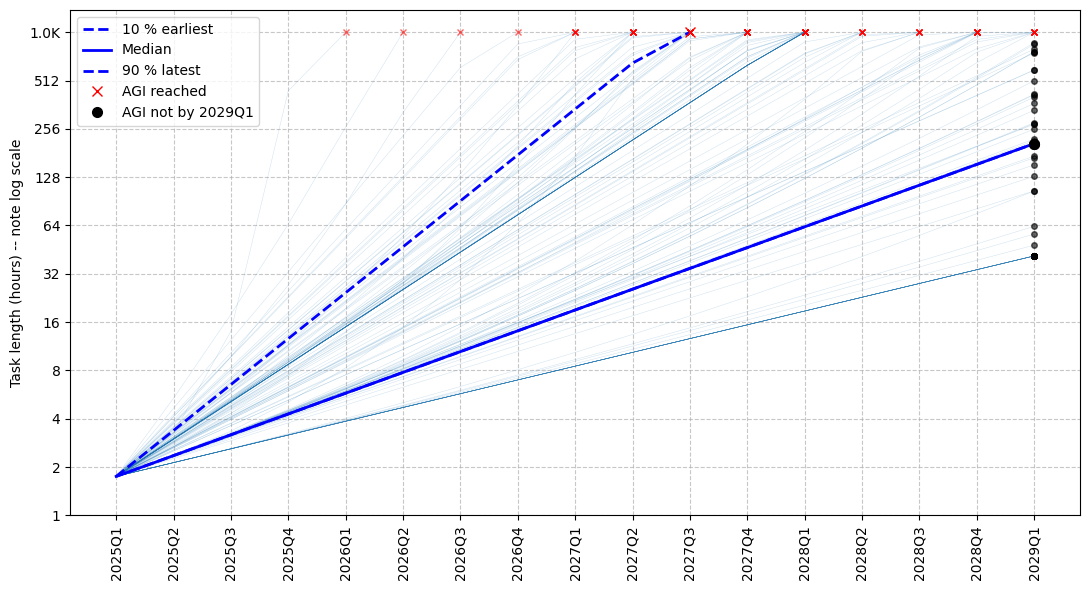

In [15]:
plot_exponential_growth(
    doubling_time_days=doubling_time,
    starting_hours=1.75,
    agi_task_length=100_000,
    shift=0,
    acceleration=acceleration,
    n_quarters=16,
    n_samples=100_000,
    n_traces=200,
    max_task_power=10,
)

In [20]:
# Sanity check WITH SHIFT=0 for public models
today = datetime(2025, 7, 1)
days_since_o3 = (today - O3_LAUNCH_DATE).days

print(f"Days since o3: {days_since_o3}")
print(f"Model predictions for PUBLIC models on July 1, 2025:\n")

# Calculate for today WITH NO SHIFT
task_lengths_today_public = np.zeros(n_samples)

for i in range(n_samples):
    if accel_samples[i] == 1:
        doublings = days_since_o3 / tau_samples[i]
        task_lengths_today_public[i] = 1.75 * (2 ** doublings)
    else:
        # Binary search for doublings
        low, high = 0, 100
        target_days = days_since_o3  # NO SHIFT
        tau0 = tau_samples[i]
        a = accel_samples[i]
        
        for _ in range(50):
            mid = (low + high) / 2
            predicted_days = tau0 * (1 - a**mid) / (1 - a) if a != 1 else mid * tau0
            
            if predicted_days < target_days:
                low = mid
            else:
                high = mid
        
        doublings = (low + high) / 2
        task_lengths_today_public[i] = 1.75 * (2 ** doublings)

task_lengths_today_public = np.minimum(task_lengths_today_public, 2000)

print(f"5th percentile:  {np.percentile(task_lengths_today_public, 5):.2f} hours")
print(f"Median:          {np.median(task_lengths_today_public):.2f} hours")
print(f"Mean:            {np.mean(task_lengths_today_public):.2f} hours")
print(f"95th percentile: {np.percentile(task_lengths_today_public, 95):.2f} hours")

print(f"\nActual observed: Claude 4 at ~1.1-1.3 hours")
print(f"\nGap: {np.median(task_lengths_today_public):.2f}hr predicted vs ~1.2hr actual")

Days since o3: 76
Model predictions for PUBLIC models on July 1, 2025:

5th percentile:  2.06 hours
Median:          2.24 hours
Mean:            2.57 hours
95th percentile: 3.17 hours

Actual observed: Claude 4 at ~1.1-1.3 hours

Gap: 2.24hr predicted vs ~1.2hr actual


/var/folders/52/t32yw5zn6yv1cxgxmn4svggw0000gn/T/ipykernel_93215/1637526161.py:24: RuntimeWarning: invalid value encountered in scalar power
  predicted_days = tau0 * (1 - a**mid) / (1 - a) if a != 1 else mid * tau0
